In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import build_vocab
from torchlake.sequence_data.controller.trainer_rnn_generator import RNNGeneratorTrainer
from torchlake.text_generation.datasets.flickr import Flickr8k, Flickr8kFromLMDB
from torchlake.text_generation.models.show_and_tell import NeuralImageCation
from torchtext.data.utils import get_tokenizer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.controller.recorder import TrainRecorder
import torchtext.transforms as T
from tqdm import tqdm

To utilize this notebook, you have to install `spacy` and download `de_core_news_sm` and `en_core_web_sm` first

# setting

In [2]:
data_path = Path("F://data/flickr8k")
data_path.mkdir(exist_ok=True)

artifacts_path = Path("../../artifacts/show-and-tell")
artifacts_path.mkdir(exist_ok=True)

In [3]:
BATCH_SIZE = 128
CONTEXT = NlpContext()

In [4]:
DEVICE = torch.device(CONTEXT.device)

# data

In [5]:
tokenizer = get_tokenizer('spacy', language='en')  # en_web_core_sm

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [6]:
IMAGE_SIZE = 224

In [7]:
image_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # extractor will do imagenet normalization, so skip it here
        A.Normalize(0, 1), 
        ToTensorV2(),
    ]
)

In [8]:
# only keep for remind me of how to use official dataset

# import joblib
# from torchvision.datasets import Flickr8k

# cache_path =  Path("./cache")

# if cache_path.exists():
#     train_iter = joblib.load(cache_path.as_posix())
# else:      
#     # sloooooooooooooooow
#     train_iter = Flickr8k(
#         data_path.joinpath("Images"),
#         data_path.joinpath("8k-pictures.html"),
#         transform=image_transform,
#     )
#     joblib.dump(train_iter, cache_path.as_posix())  

In [9]:
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
# )

In [10]:
# train_iter.annotations

In [ ]:
# create lmdb one
# import lmdb

# env = lmdb.Environment(
#     data_path.joinpath("flickr8k").as_posix(),
#     map_size=1 << 35, # 32GB
# )
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
# )

# train_iter.to_lmdb(env)

In [12]:
train_iter = Flickr8kFromLMDB(
    data_path.joinpath("flickr8k").as_posix(),
)

In [13]:
vocab = build_vocab(
    map(lambda pair: tokenizer(pair[1].lower().strip()), train_iter),
    CONTEXT,
)

In [14]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

3102

In [15]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [16]:
def text_pipeline(corpus: str) -> list[torch.Tensor]:
    x = corpus.lower().strip()
    x = tokenizer(x)
    x = text_transform(x)
    return x

In [17]:
# 1GB
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
#     image_transform,
#     text_pipeline,
# )

In [18]:
train_iter.env.close()

In [19]:
train_iter = Flickr8kFromLMDB(
    data_path.joinpath("flickr8k").as_posix(),
    image_transform,
    text_pipeline,
)

In [20]:
for img, caption in train_iter:
    print(img.shape, caption.shape)
    break

torch.Size([3, 224, 224]) torch.Size([256])


In [21]:
# def collate_fn(batch):
#     image_batch, label_batch = [], []

#     for x, y in batch:
#         y = text_pipeline(y)
#         for yi in y:
#             image_batch.append(x)
#             label_batch.append(yi)

#     return torch.stack(image_batch), torch.stack(label_batch)

In [22]:
NUM_WORKERS = get_num_workers()

In [23]:
train_loader = DataLoader(
    train_iter,
    batch_size=BATCH_SIZE,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)

# test_loader = DataLoader(
#     val_iter,
#     batch_size=BATCH_SIZE,
#     collate_fn=collate_fn,
#     num_workers=NUM_WORKERS,
    # pin_memory=True,
# )

In [24]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128, 256])


# Model

In [25]:
from functools import partial

In [26]:
from torchlake.common.models import VGGFeatureExtractor

extractor = VGGFeatureExtractor("vgg16", "relu", trainable=False)
extractor.forward = partial(extractor.forward, target_layer_names=["5_3"])

In [27]:
# from torchlake.common.models import ResNetFeatureExtractor

# extractor = ResNetFeatureExtractor("resnet50", "block", trainable=False)
# extractor.forward = partial(extractor.forward, target_layer_names=["4_1"])

In [ ]:
from torchlake.sequence_data.models.base import RNNGenerator
from torchlake.sequence_data.models.lstm import LSTMDiscriminator

decoder = RNNGenerator(
    LSTMDiscriminator(
        VOCAB_SIZE,
        # should be the same as convlution feature map
        embed_dim=512,
        hidden_dim=256,
        output_size=VOCAB_SIZE,
        num_layers=2,
        bidirectional=True,
        context=CONTEXT,
    )
)

In [28]:
model = NeuralImageCation(
    extractor,
    decoder,
    context=CONTEXT,
)

In [29]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
NeuralImageCation                        --
├─VGGFeatureExtractor: 1-1               --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  (1,792)
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  (36,928)
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  (73,856)
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  (147,584)
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 (295,168)
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 (590,080)
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 (590,080)
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17              --
│    │    └─Conv2d: 3-18  

# Training

In [30]:
EPOCHES = 10

In [31]:
trainer = RNNGeneratorTrainer(EPOCHES, DEVICE, feature_last=True)
trainer.set_curriculum_strategy("inverse_sigmoid", k=10)

In [32]:
criterion = nn.CrossEntropyLoss(ignore_index=CONTEXT.padding_idx, reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
recorder = TrainRecorder(total_epoch=EPOCHES)
recorder.increment_data_size(len(train_iter))

In [34]:
recorder.data_size

40455

In [35]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [36]:
scaler = torch.cuda.amp.GradScaler()

In [37]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    recorder=recorder,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 317/317 [06:07<00:00,  1.16s/it]


Epoch 1 : 0.026358678918173013 (0%)


100%|██████████| 317/317 [06:06<00:00,  1.16s/it]


Epoch 2 : 0.020990287593114998 (-20%)


100%|██████████| 317/317 [06:29<00:00,  1.23s/it]


Epoch 3 : 0.01906968619351686 (-9%)


100%|██████████| 317/317 [05:50<00:00,  1.11s/it]


Epoch 4 : 0.017881154471842818 (-6%)


100%|██████████| 317/317 [05:27<00:00,  1.03s/it]


Epoch 5 : 0.01696805026943464 (-5%)


100%|██████████| 317/317 [05:30<00:00,  1.04s/it]


Epoch 6 : 0.01615550237803446 (-5%)


 98%|█████████▊| 311/317 [05:26<00:06,  1.05s/it]


KeyboardInterrupt: 

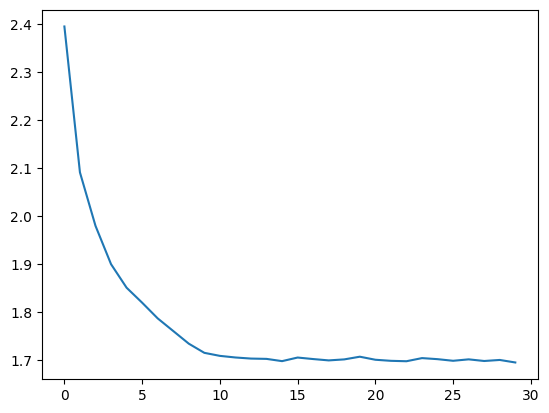

In [34]:
plt.plot(training_loss)

# Save

In [32]:
model_path = artifacts_path.joinpath("show-and-tell.vgg16.2.pth")

In [33]:
torch.save(model.state_dict(), model_path.as_posix())

In [34]:
get_file_size(model_path)

'80.3MiB'

In [35]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Evaluate

## BLEU score

In [19]:
from torchmetrics.text import BLEUScore

In [20]:
metric = BLEUScore()

In [ ]:
model.eval()
running_loss = 0.0
data_count = 0
with torch.no_grad():
    for img, text in tqdm(train_loader):
        data_count += len(img)
        img = img.to(DEVICE)
        label = text.to(DEVICE)

        output = model(img, teacher_forcing_ratio=0).argmax(-1)
        
        # list of string
        preds = []
        for o in output.tolist():
            translated = vocab.lookup_tokens(o)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            preds.append(" ".join(translated[start_idx+1 : end_idx]))
        
        # list of strings
        # i.e. list of candidates
        labels = []
        for l in label.tolist():
            translated = vocabs[TRG_LANGUAGE].lookup_tokens(l)
            start_idx, end_idx = translated.index(CONTEXT.bos_str), translated.index(CONTEXT.eos_str)
            labels.append(" ".join(translated[start_idx+1 : end_idx]))
            
        metric.update(preds, labels)

In [ ]:
metric.compute()

## Compare to groundtruth

In [54]:
CLIP = 5

model.eval()
with torch.no_grad():
    for i, (img, text) in enumerate(train_iter):
        ori_source, ori_target = img, text
        img = img.unsqueeze(0)
        img = img.to(DEVICE)
        
        text = text.unsqueeze(0)
        text = text.to(DEVICE)
        
        output = model.predict(img, topk=3)[0]
        
        # if EOS_IDX in outputs:
        output = vocab.lookup_tokens(output.tolist())
        start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(CONTEXT.eos_str)
        target_tokens = vocab.lookup_tokens(ori_target.tolist())
        target_start_idx, target_end_idx = target_tokens.index(CONTEXT.bos_str), target_tokens.index(CONTEXT.eos_str)
        print(f'第{i+1}句')
        print('target:', *target_tokens[target_start_idx+1:target_end_idx], sep=' ')
        print('output:', *output[start_idx+1:end_idx], sep=' ')
        
        if i+1==CLIP: break

第1句
target: b'a child in a pink dress is climbing up a set of stairs in an <unk> way . '
output: b'a young man is sitting on a table in front of him in a bus '
第2句
target: b'a girl going into a wooden building . '
output: b'a young man is sitting on a table in front of him in a bus '
第3句
target: b'a little girl climbing into a wooden playhouse . '
output: b'a young man is sitting on a table in front of him in a bus '
第4句
target: b'a little girl climbing the stairs to her playhouse . '
output: b'a little girl is jumping on a tree . '
第5句
target: b'a little girl in a pink dress going into a wooden <unk> . '
output: b'a young man is sitting on a table in front of him in a bus '


## In the wild

In [55]:
from torchlake.common.utils.image import load_image

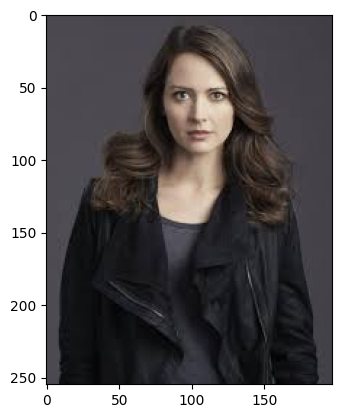

In [66]:
img = load_image("../../data/contents/black-woman.jpg", is_numpy=True)
plt.imshow(img)

In [67]:
model.eval()
with torch.no_grad():
    img = image_transform(image=img)["image"]
    img = img.unsqueeze(0).to(DEVICE)
    
    output = model(img, topk=2)

In [68]:
for v in vocab.lookup_tokens(output[0].tolist()):
    if v not in CONTEXT.special_tokens:
        print(v, end=" ")
    if v == CONTEXT.eos_str:
        break

b'a woman wearing a black shirt and a . ' 